# `micapipe v0.2.2|3` fsLR-5k maps and gradients

## load libraries and standard surfaces

In [1]:
import numpy as np
import os
import glob
import nibabel as nb
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps

# Set the micapipe outputs directory
out = '/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0'

# Change working directory
os.chdir(out)

# Load fsLR-5k inflated surface
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
i5_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
i5_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

# fsLR-5k mask
mask_lh = nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_rh = nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)


## Functions to load fsLR-5k connectomes

In [2]:
def load_mpc(File):
    """Loads and process a MPC"""

    # Load file
    mpc = nb.load(File).darrays[0].data
    
    # Mirror the lower triangle
    mpc = np.triu(mpc,1)+mpc.T
    
    # Replace infinite values with epsilon
    mpc[~np.isfinite(mpc)] = np.finfo(float).eps
    
    # Replace 0 with epsilon
    mpc[mpc==0] = np.finfo(float).eps
    
    # retun the MPC
    return(mpc)

def load_gd(File):
    """Loads and process a GD"""
    
    # load the matrix
    mtx_gd = nb.load(File).darrays[0].data
    
    return mtx_gd

def load_fc(File):
    """Loads and process a functional connectome"""
    
    # load the matrix
    FC = nb.load(File).darrays[0].data
    
    # Fisher transform
    FCz = np.arctanh(FC)

    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0
    
    # Mirror the matrix
    FCz = np.triu(FCz,1)+FCz.T
    return FCz

def load_sc(File):
    """Loads and process a structura connectome"""
    
    # load the matrix
    mtx_sc = nb.load(File).darrays[0].data
    
    # Mirror the matrix
    mtx_sc = np.triu(mtx_sc,1)+mtx_sc.T
    
    return mtx_sc

## Functions to calculate fsLR-5k diffusion maps

In [3]:
def fslr5k_dm_lr(mtx, mask_5k, Ngrad=3, log=True):
    """
    Create the gradients from the mtx or GD matrix.
    Use log=False for GD gradients
    """
    if log != True:
        mtx_log = mtx
    else:
        # log transform the connectome
        mtx_log = np.log(mtx)
    
    # Replace NaN with 0
    mtx_log[np.isnan(mtx_log)] = 0
    
    # Replace negative infinite with 0
    mtx_log[np.isneginf(mtx_log)] = 0
    
    # Replace infinite with 0
    mtx_log[~np.isfinite(mtx_log)] = 0

    # replace 0 values with almost 0
    mtx_log[mtx_log==0] = np.finfo(float).eps
    
    # Left and right mask
    indx_L = np.where(mask_5k[0:4842]==1)[0]
    indx_R = np.where(mask_5k[4842:9684]==1)[0]
    
    # Left and right SC
    mtx_L = mtx_log[0:4842, 0:4842]
    mtx_R = mtx_log[4842:9684, 4842:9684]
    
    # Slice the matrix
    mtx_L_masked = mtx_L[indx_L, :]
    mtx_L_masked = mtx_L_masked[:, indx_L]  
    mtx_R_masked = mtx_R[indx_R, :]
    mtx_R_masked = mtx_R_masked[:, indx_R]

    # mtx Left hemi
    mtx_L = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    mtx_L.fit(mtx_L_masked, sparsity=0)

    # mtx Right hemi
    mtx_R = GradientMaps(n_components=Ngrad, alignment='procrustes', kernel='normalized_angle'); # align right hemi to left hemi
    mtx_R.fit(mtx_R_masked, sparsity=0, reference=mtx_L.gradients_)

    # Left and right gradients concatenated
    mtx_gradients = np.concatenate((mtx_L.gradients_, mtx_R.aligned_), axis=0)
    
    # Boolean mask
    mask_surf = mask_5k != 0
    
    # Get the index of the non medial wall regions
    indx = np.where(mask_5k==1)[0]

    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(mtx_gradients.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g
        grad[i] = g_nan
    
    return(mtx_gradients, grad)

def fslr5k_dm(mtx, mask, Ngrad=3, Smooth=False, S=0.9):
    """Create the gradients from the MPC matrix"""
    # Cleanup before diffusion embeding
    mtx[~np.isfinite(mtx)] = 0
    mtx[np.isnan(mtx)] = 0
    mtx[mtx==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mask==1)[0]

    # Slice the matrix
    mtx_masked = mtx[indx, :]
    mtx_masked = mtx_masked[:, indx]

    # Calculate the gradients
    gm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel='normalized_angle')
    gm.fit(mtx_masked, sparsity=S)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    
    # Boolean mask
    mask_surf = mask != 0
    
    for i, g in enumerate(gm.gradients_.T[0:Ngrad,:]):
        
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g
        grad[i] = g_nan
    
    return(gm, grad)


## Global variables

In [4]:
# Shape of the fsLR-5k matrices
N5k = 9684

# Number of gradients to calculate
Ngrad=10

# Number of gradients to calculate
Nplot=3

# Labels for plotting based on Ngrad
labels=['G'+str(x) for x in list(range(1,Nplot+1))]


# Geodesic Distance

In [5]:
# List all the files
gd_file = sorted(glob.glob(f"sub-*/ses-*/dist/*_surf-fsLR-5k_GD.shape.gii"))
N = len(gd_file)
print(f"Numer of GD: {N}")   
    
# Loads all the GD fsLR-5k matrices
gd_5k=np.empty([N5k, N5k, len(gd_file)], dtype=float)
for i, f in enumerate(gd_file):
    gd_5k[:,:,i] = load_gd(f)

# Calculate the mean connectome
gd_5k_mean = np.mean(gd_5k, axis=2)


Numer of GD: 44


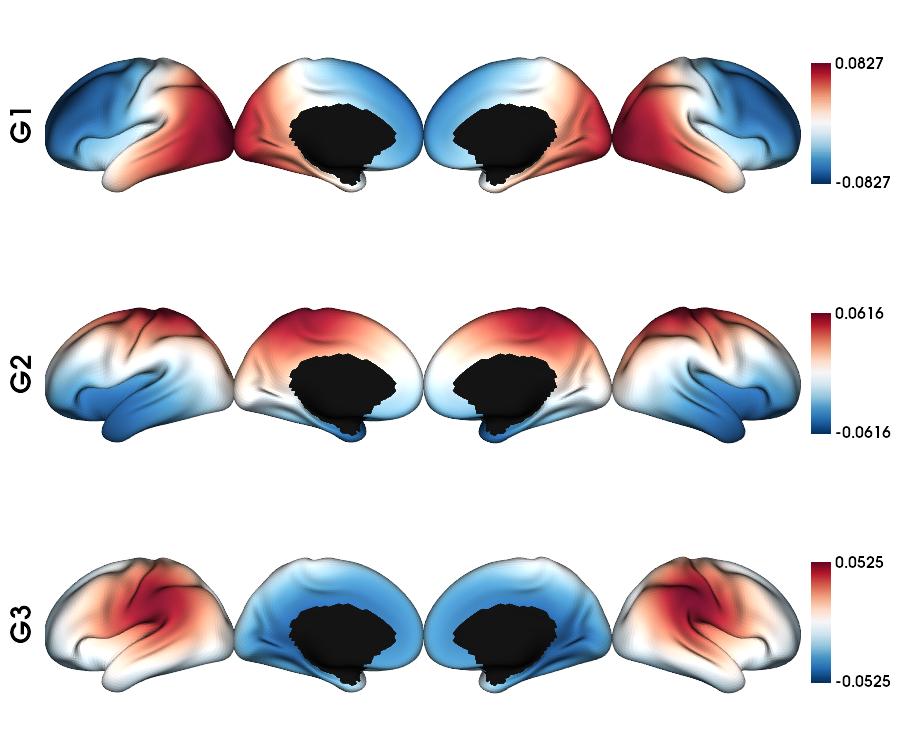

In [6]:
# Calculate the gradients
gd_dm, grad = fslr5k_dm_lr(gd_5k_mean, mask_5k, Ngrad=Ngrad, log=False)

# plot the gradients
plot_hemispheres(i5_lh, i5_rh, array_name=grad[0:Nplot], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})


In [7]:
# cleanup
del(gd_5k, gd_5k_mean, gd_dm)

# Structural Connectome

In [8]:
# List all the files
sc_file = sorted(glob.glob(f"sub-*/ses-*/dwi/connectomes/*_surf-fsLR-5k_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii"))
N = len(sc_file)
print(f"Numer of SC: {N}") 

# Loads all the MPC fsLR-5k matrices
sc_5k=np.empty([N5k, N5k, len(sc_file)], dtype=float)

# Load the SC and weight it by the edge length
for i, f in enumerate(sc_file):
    sc_5k[:,:,i] = load_sc(f)
    
# Calculate the mean connectome
sc_5k_mean = np.mean(sc_5k, axis=2)


Numer of SC: 33


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_21566/1512444605.py:10: RuntimeWarning: divide by zero encountered in log
  mtx_log = np.log(mtx)


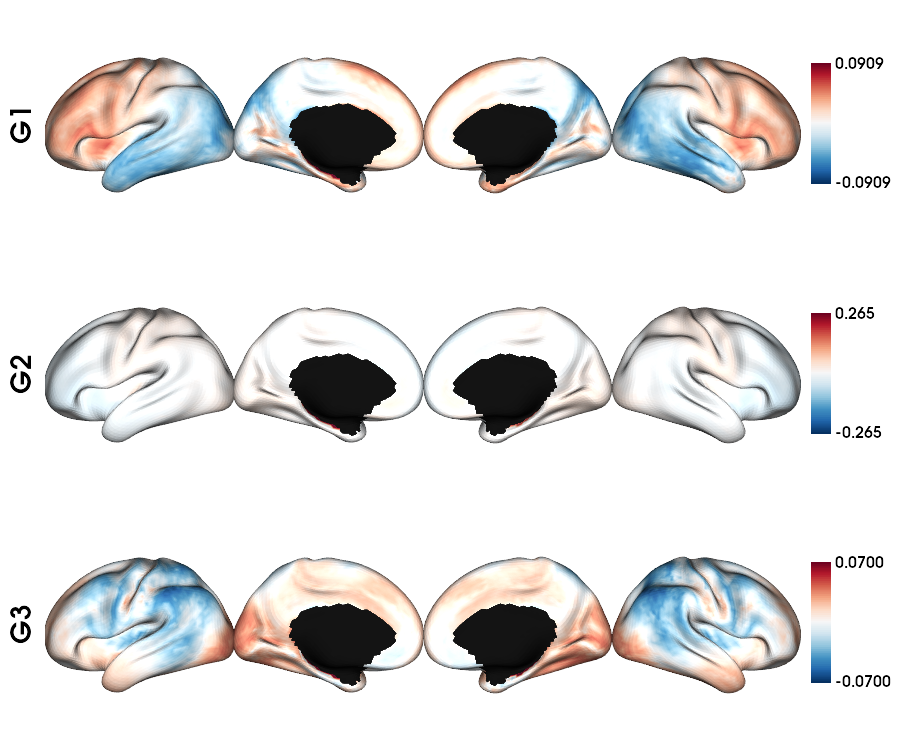

In [9]:
# Calculate the gradients
sc_dm, grad = fslr5k_dm_lr(sc_5k_mean, mask_5k, Ngrad=Ngrad, log=True)

# plot the gradients
plot_hemispheres(i5_lh, i5_rh, array_name=grad[0:Nplot], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})


In [10]:
# cleanup
del(sc_5k, sc_5k_mean, sc_dm)

# Functional Connectome

In [11]:
# List all the files
fc_file = sorted(glob.glob(f"sub-*/ses-*/func/desc-me_task-rest_bold/surf/*_surf-fsLR-5k_desc-FC.shape.gii"))
N = len(fc_file)
print(f"Numer of FC: {N}") 

# Loads all the MPC fsLR-5k matrices
fc_5k=np.empty([N5k, N5k, len(fc_file)], dtype=float)
for i, f in enumerate(fc_file):
    fc_5k[:,:,i] = load_fc(f)

# Calculate the mean connectome
fc_5k_mean = np.mean(fc_5k, axis=2)


Numer of FC: 49


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_21566/3092911582.py:34: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


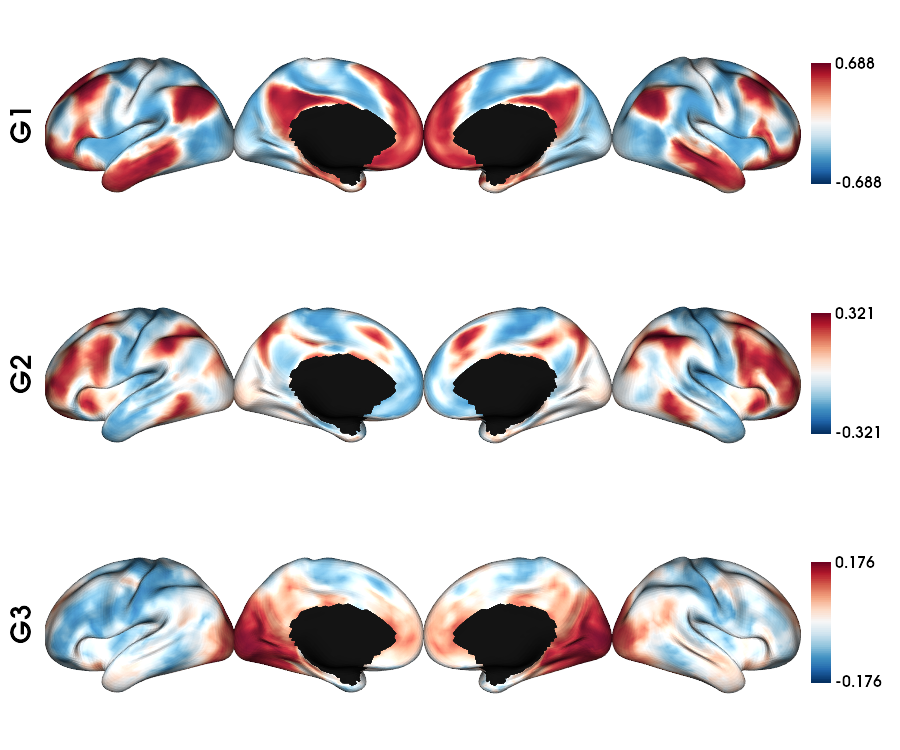

In [12]:
# Calculate the gradients
fc_dm, grad = fslr5k_dm(fc_5k_mean, mask_5k, Ngrad=Ngrad, S=0)

# plot the gradients
plot_hemispheres(i5_lh, i5_rh, array_name=grad[0:Nplot], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})


In [13]:
# cleanup
del(fc_5k_mean, fc_5k, fc_dm)

# MPC T1map

In [14]:
# MPC T1map
qmri='T1map'
mpc_file = sorted(glob.glob(f"sub-*/ses-*/mpc/acq-{qmri}/*surf-fsLR-5k_desc-MPC.shape.gii"))
N = len(mpc_file)
print(f"Numer of MPC: {N}") 

# Loads all the MPC fsLR-5k matrices
mpc_5k=np.empty([N5k, N5k, len(mpc_file)], dtype=float)
for i, f in enumerate(mpc_file):
    mpc_5k[:,:,i] = load_mpc(f)
    
# Mean group MPC colums
mpc_5k_mean = np.mean(mpc_5k, axis=2)


Numer of MPC: 43


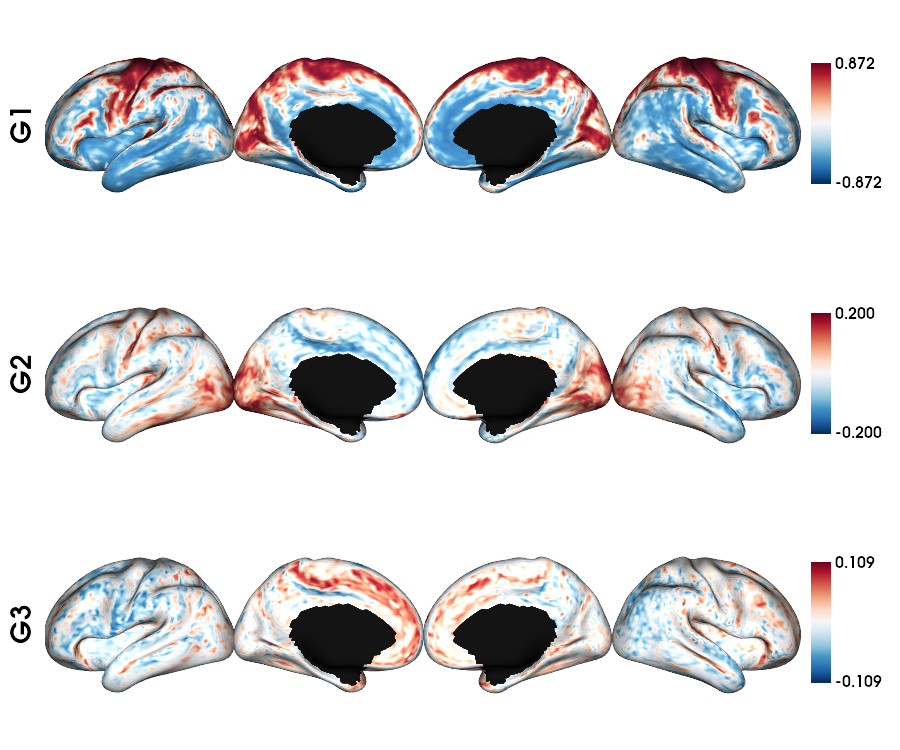

In [15]:
# Calculate the gradients
mpc_dm, grad = fslr5k_dm(mpc_5k_mean, mask_5k, Ngrad=Ngrad, Smooth=False, S=0)

# plot the gradients
plot_hemispheres(i5_lh, i5_rh, array_name=grad[0:Nplot], cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.3, size=(900, 750), embed_nb=True, color_range='sym',
  color_bar='right', label_text={'left': labels})
